In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def prepare_image(file):
    img_path = '/content/drive/MyDrive/Colab Notebooks 1/kaggle/Skin-Disease-Dataset/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [ ]:
def prepare_any_image(file):
    img = image.load_img(file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [ ]:
# Organize data into train, valid, test dirs
os.chdir('/content/drive/MyDrive/Colab Notebooks 1/kaggle/Skin-Disease-Dataset')
if os.path.isdir('train/Acne and Rosacea Photos/') is False: 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(0, 3):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..')

In [8]:
train_path = '/content/drive/MyDrive/Colab Notebooks 1/kaggle/Skin-Disease-Dataset/train'
valid_path = '/content/drive/MyDrive/Colab Notebooks 1/kaggle/Skin-Disease-Dataset/valid'
test_path = '/content/drive/MyDrive/Colab Notebooks 1/kaggle/Skin-Disease-Dataset/test'

In [9]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=3)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=3)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=3, shuffle=False)

Found 1591 images belonging to 3 classes.
Found 501 images belonging to 3 classes.
Found 501 images belonging to 3 classes.


# Modify Model

In [ ]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [ ]:
x = mobile.layers[-6].output
output = Dense(units=3, activation='softmax')(x)

In [ ]:
model = Model(inputs=mobile.input, outputs=output)

In [ ]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

# Train The Model

In [ ]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=5,
            verbose=2
)

Epoch 1/5
531/531 - 19s - loss: 0.8203 - accuracy: 0.6600 - val_loss: 0.5245 - val_accuracy: 0.8144
Epoch 2/5
531/531 - 17s - loss: 0.5230 - accuracy: 0.8014 - val_loss: 0.5197 - val_accuracy: 0.8044
Epoch 3/5
531/531 - 17s - loss: 0.3992 - accuracy: 0.8504 - val_loss: 0.5078 - val_accuracy: 0.8503
Epoch 4/5
531/531 - 17s - loss: 0.3095 - accuracy: 0.9026 - val_loss: 0.5888 - val_accuracy: 0.8084
Epoch 5/5
531/531 - 17s - loss: 0.2506 - accuracy: 0.9221 - val_loss: 0.3505 - val_accuracy: 0.8802


In [4]:
model = load_model('/content/drive/MyDrive/Colab Notebooks 1/kaggle/Skin-Disease-Dataset/SD_model_5_epochs_3M.h5')

In [10]:
test_labels = test_batches.classes

In [11]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [12]:
predictions

array([[9.9697685e-01, 1.8321015e-03, 1.1911473e-03],
       [6.4542133e-01, 2.1938072e-01, 1.3519795e-01],
       [9.2399472e-01, 7.1169958e-02, 4.8353085e-03],
       ...,
       [2.2049543e-02, 1.5374264e-01, 8.2420784e-01],
       [5.6379043e-02, 3.6365289e-04, 9.4325733e-01],
       [7.6083416e-01, 3.0775707e-02, 2.0839012e-01]], dtype=float32)

In [13]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [28]:
Num_img = np.array([313,74,117])
cm_normalized = np.round(cm / Num_img[:, None], 2)

In [22]:
test_batches.class_indices

{'Acne and Rosacea Photos': 0,
 'Cellulitis Impetigo and other Bacterial Infections': 1,
 'Melanoma Skin Cancer Nevi and Moles': 2}

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[293  16   3]
 [ 17  49   7]
 [  7  10  99]]
Recall    =   0.8212612388923205
Precision =   0.8286268116291559
Accuracy  =   0.8802395209580839


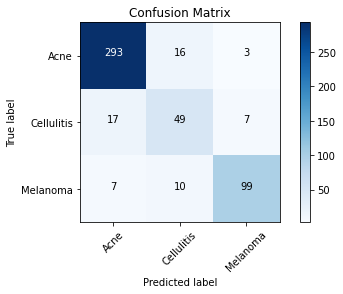

In [26]:
cm_plot_labels = ['Acne','Cellulitis','Melanoma']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
print("Recall    =  ", metrics.recall_score(y_true=test_labels, y_pred=predictions.argmax(axis=1), average='macro'))
print("Precision =  ",metrics.precision_score(y_true=test_labels, y_pred=predictions.argmax(axis=1), average='macro'))
print("Accuracy  =  ", metrics.accuracy_score(y_true=test_labels, y_pred=predictions.argmax(axis=1)))

Confusion matrix, without normalization
[[0.94 0.05 0.01]
 [0.23 0.66 0.09]
 [0.06 0.09 0.85]]


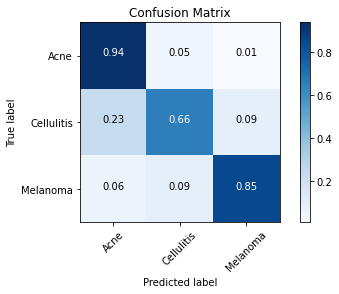

In [29]:
plot_confusion_matrix(cm=cm_normalized, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks 1'

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks 1/kaggle/Skin-Disease-Dataset/SD_model_5_epochs_3M.h5')

In [ ]:
model_load = load_model('/content/drive/MyDrive/Colab Notebooks 1/kaggle/Skin-Disease-Dataset/SD_model_5_epochs_3M.h5')

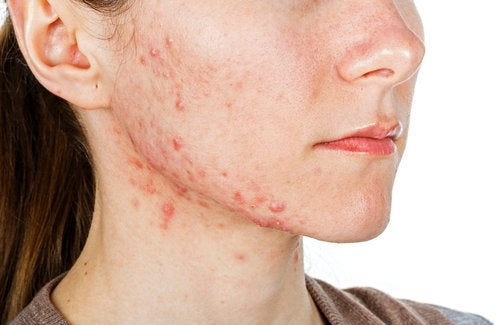

In [ ]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/tratamente-interne-pentru-acnee.jpg', width=300,height=200) 

In [ ]:
preprocessed_image = prepare_any_image('/content/drive/MyDrive/tratamente-interne-pentru-acnee.jpg')
predictions = model_load.predict(preprocessed_image)

In [ ]:
predictions

array([[0.45934874, 0.5359439 , 0.00470731]], dtype=float32)

In [ ]:
def decode_prediction(preds, top=3, class_list_path=None):
    if len(preds.shape) != 2 or preds.shape[1] != 3:
        raise ValueError('`decode_predictions` expects '
                     'a batch of predictions '
                     '(i.e. a 2D array of shape (samples, 10)). '
                     'Found array with shape: ' + str(preds.shape))
    CLASS_INDEX = json.load(open(class_list_path))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[1], reverse=True)
        results.append(result)
    return results


In [ ]:
import json
results = decode_prediction(predictions, 3, '/content/drive/MyDrive/Colab Notebooks 1/kaggle/Skin-Disease-Dataset/imagenet_class_index_3M.json')

In [ ]:
results

[[('Cellulitis', 0.5359439), ('Acne', 0.45934874), ('Melanoma', 0.0047073127)]]